# Neural Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Embedding, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import RandomUniform, he_normal, he_uniform
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [2]:
# TODO could try different thresholds for played
train = pd.read_csv("data\\train-plays.csv").drop(columns=["norm_amount", "amount"])
test = pd.read_csv("data\\test-plays.csv").drop(columns=["norm_amount", "amount"])
game_coding = pd.read_csv("data\\game-coding.csv")

## Format training data

In [3]:
train['played'] = 1

In [4]:
rand_users = np.random.randint(0, train.user_id.unique().size, train.shape[0] * 100)
rand_games = np.random.randint(0, train.game_id.unique().size, train.shape[0] * 100)
neg_train = pd.DataFrame({"user_id":rand_users, "game_id":rand_games})
neg_train

,user_id,game_id
0,315,710
1,1111,863
2,570,614
3,1005,917
4,1155,890
...,...,...
1822345,280,745
1822346,508,831
1822347,480,625
1822348,8,461


In [5]:
train = train.append(neg_train).drop_duplicates(subset=['game_id', 'user_id'])
train.played = np.where(train.played != 1, 0, 1)
train = train.sample(frac=1.0)
train

,game_id,user_id,played
958967,445,698,0
260897,685,86,0
188740,642,1132,0
208459,549,726,0
228704,967,430,0
...,...,...,...
1209652,299,627,0
809356,679,982,0
1755014,444,883,0
656584,879,123,0


In [6]:
print(train[train.played == 0].shape[0]/train.shape[0])
print(train[train.played == 1].shape[0]/train.shape[0])

0.9616168785898281
0.03838312141017189


In [7]:
# check to make sure didn't introduce conflicting neg training instances
train.groupby(by=['user_id']).agg({'game_id':lambda x: x.unique().size == x.size})['game_id'].all()

True

## Neural Network Construction

In [8]:
n_latent_factors = 16
n_epochs = 100

### Multi-Layer Perceptron part of model

In [9]:
# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='MLP-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='MLP-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='MLP-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='MLP-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='MLP-Flatten-Users')(user_embedding)

mlp_layer = keras.layers.concatenate([game_vec, user_vec], name="MLP-User-Games")

for i in [4, 2, 1, 0.5, 0.25, 0]:
  mlp_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  mlp_layer = Dense(math.floor(n_latent_factors * i), activation='relu', 
              kernel_initializer='he_uniform', 
              activity_regularizer=l2(0.01))(mlp_layer)
  if i == 4:
    mlp_layer = BatchNormalization()(mlp_layer)
    mlp_layer = Dropout(0.2)(mlp_layer)

mlp = Model(inputs=[user_input, game_input], outputs=mlp_output)
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [10]:
# train mlp weights
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
mlp_history = mlp.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

Train on 949558 samples
Epoch 1/100
949558/949558 [==============================] - 28s 30us/sample - loss: 0.1719 - binary_accuracy: 0.9597
Epoch 2/100
949558/949558 [==============================] - 25s 27us/sample - loss: 0.1421 - binary_accuracy: 0.9617
Epoch 3/100
949558/949558 [==============================] - 19s 20us/sample - loss: 0.1372 - binary_accuracy: 0.9620
Epoch 4/100
949558/949558 [==============================] - 20s 21us/sample - loss: 0.1349 - binary_accuracy: 0.9620
Epoch 5/100
949558/949558 [==============================] - 19s 20us/sample - loss: 0.1332 - binary_accuracy: 0.9621
Epoch 6/100
949558/949558 [==============================] - 19s 20us/sample - loss: 0.1323 - binary_accuracy: 0.9621
Epoch 7/100
949558/949558 [==============================] - 19s 20us/sample - loss: 0.1315 - binary_accuracy: 0.9621
Epoch 8/100
949558/949558 [==============================] - 19s 20us/sample - loss: 0.1306 - binary_accuracy: 0.9622
Epoch 9/100
949558/949558 [=====

Text(0, 0.5, 'Training Error')

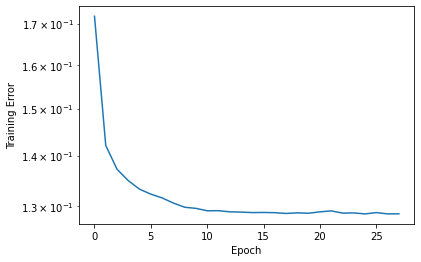

In [11]:
pd.Series(mlp_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [12]:
# lock mlp weights
mlp.trainable = False
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

### Generalized Matrix Factorization part of model

In [13]:
# game inputs and embeddings
game_input = keras.layers.Input(shape=[1], name='GMF-Game')
game_embedding = keras.layers.Embedding(train.game_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-Game-Embedding')(game_input)
game_vec = keras.layers.Flatten(name='GMF-Flatten-Games')(game_embedding)

# user inputs and embeddings
user_input = keras.layers.Input(shape=[1], name='GMF-User')
user_embedding = keras.layers.Embedding(train.user_id.unique().size, n_latent_factors,
                                          embeddings_regularizer=l2(1e-6), 
                                          embeddings_constraint='NonNeg',
                                          name='GMF-User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='GMF-Flatten-Users')(user_embedding)

prod = keras.layers.dot([user_vec, game_vec], axes=1, name='Dot-Product')

gmf = Model(inputs=[user_input, game_input], outputs=prod)
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [14]:
# train gmf weights
gmf_history = gmf.fit([train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs)

Train on 949558 samples
Epoch 1/100
949558/949558 [==============================] - 10s 10us/sample - loss: 0.0345 - mae: 0.0605 - mse: 0.0343
Epoch 2/100
949558/949558 [==============================] - 9s 10us/sample - loss: 0.0332 - mae: 0.0653 - mse: 0.0330
Epoch 3/100
949558/949558 [==============================] - 9s 9us/sample - loss: 0.0320 - mae: 0.0667 - mse: 0.0317
Epoch 4/100
949558/949558 [==============================] - 9s 9us/sample - loss: 0.0311 - mae: 0.0669 - mse: 0.0307
Epoch 5/100
949558/949558 [==============================] - 9s 9us/sample - loss: 0.0304 - mae: 0.0668 - mse: 0.0300
Epoch 6/100
949558/949558 [==============================] - 9s 9us/sample - loss: 0.0300 - mae: 0.0665 - mse: 0.0294
Epoch 7/100
949558/949558 [==============================] - 9s 9us/sample - loss: 0.0296 - mae: 0.0661 - mse: 0.0290
Epoch 8/100
949558/949558 [==============================] - 9s 9us/sample - loss: 0.0294 - mae: 0.0659 - mse: 0.0287
Epoch 9/100
949558/949558 [==

Text(0, 0.5, 'Training Error')

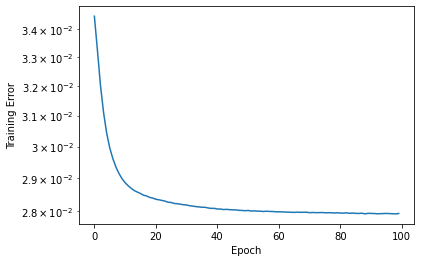

In [15]:
pd.Series(gmf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

In [16]:
# lock gmf weights
gmf.trainable = False
gmf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [17]:
# Combining MLP and GMF parts of the model
mlp_gmf = Concatenate()([mlp.output, gmf.output])
ncf_output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='he_uniform', name='NCF-Output')(mlp_gmf)
ncf = Model([mlp.input, gmf.input], ncf_output)
ncf.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [18]:
ncf.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
MLP-Game (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-User (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
MLP-Game-Embedding (Embedding)  (None, 1, 32)        33376       MLP-Game[0][0]                   
__________________________________________________________________________________________________
MLP-User-Embedding (Embedding)  (None, 1, 32)        37120       MLP-User[0][0]                   
____________________________________________________________________________________________

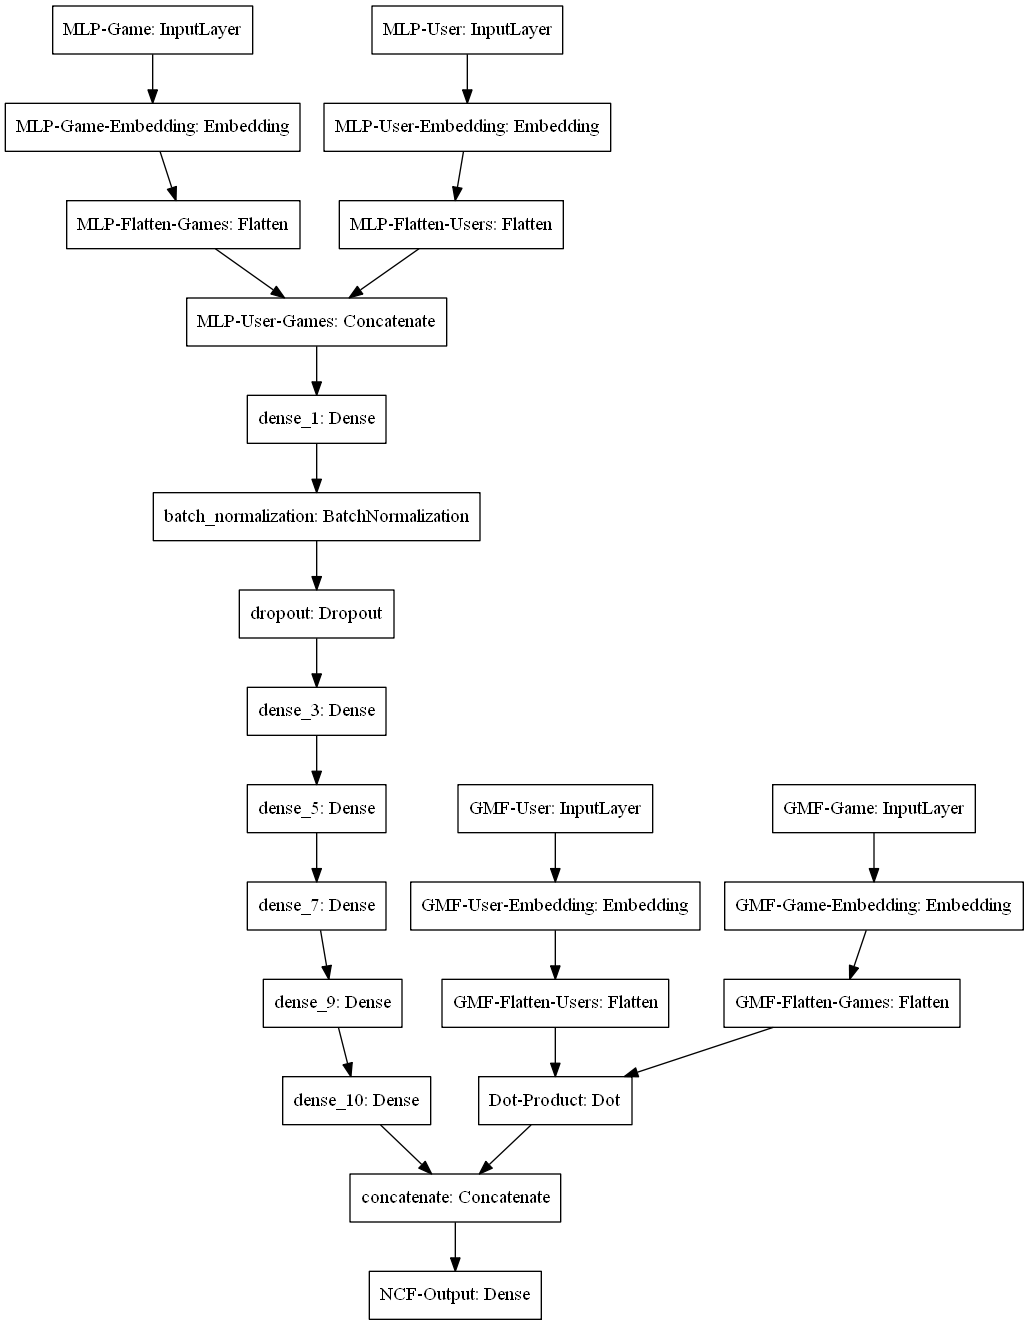

In [19]:
plot_model(ncf)

## Model Training

In [20]:
# train ncf
early_stop = keras.callbacks.EarlyStopping(monitor='binary_accuracy', min_delta = 0.0001, patience=10)
ncf_history = ncf.fit([train.user_id, train.game_id, train.user_id, train.game_id], train.played, batch_size=256, epochs=n_epochs, callbacks=[early_stop])

Train on 949558 samples
Epoch 1/100
949558/949558 [==============================] - 14s 15us/sample - loss: 0.2228 - binary_accuracy: 0.9616
Epoch 2/100
949558/949558 [==============================] - 12s 13us/sample - loss: 0.1668 - binary_accuracy: 0.9616
Epoch 3/100
949558/949558 [==============================] - 12s 13us/sample - loss: 0.1615 - binary_accuracy: 0.9616
Epoch 4/100
949558/949558 [==============================] - 12s 13us/sample - loss: 0.1571 - binary_accuracy: 0.9616
Epoch 5/100
949558/949558 [==============================] - 13s 13us/sample - loss: 0.1529 - binary_accuracy: 0.9616
Epoch 6/100
949558/949558 [==============================] - 13s 13us/sample - loss: 0.1491 - binary_accuracy: 0.9616
Epoch 7/100
949558/949558 [==============================] - 13s 13us/sample - loss: 0.1456 - binary_accuracy: 0.9617
Epoch 8/100
949558/949558 [==============================] - 12s 13us/sample - loss: 0.1424 - binary_accuracy: 0.9619
Epoch 9/100
949558/949558 [=====

Text(0, 0.5, 'Training Error')

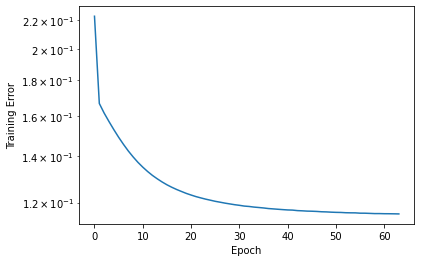

In [21]:
pd.Series(ncf_history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")

## Model Analysis

In [22]:
def recommend_game(uid, model, n=10):
    uid_array = np.repeat(uid, game_coding.game_id.size)
    recs = np.ndarray.flatten(model.predict([uid_array, game_coding.game_id, uid_array, game_coding.game_id]))
    recs_df =  pd.DataFrame({'game_id':game_coding.game_id, 'rec_confidence':recs})
    return set(recs_df.sort_values(by='rec_confidence', ascending=False).head(10).game_id)

In [23]:
test['recommended'] = np.vectorize(recommend_game)(test.user_id.unique(), ncf)

In [34]:
game_coding[game_coding.game_id == test.game_id[1156]]

,game_id,game_name
656,656,Heroes & Generals


In [35]:
game_coding[game_coding.game_id.isin(test.recommended[1156])]

,game_id,game_name
109,109,PAYDAY 2
171,171,Killing Floor
343,343,Counter-Strike Nexon Zombies
353,353,No More Room in Hell
399,399,Nosgoth
544,544,Dead Island Epidemic
656,656,Heroes & Generals
807,807,Cry of Fear
931,931,sZone-Online
954,954,Survarium


In [25]:
test['in_recommendations'] = np.vectorize(lambda gid, recs: 1 if gid in recs else 0)(test.game_id, test.recommended)
test.in_recommendations.sum() / test.in_recommendations.size

0.15689655172413794

In [26]:
games_recommended = set()
np.vectorize(lambda curr_games, total: total.update(curr_games))(test.recommended, games_recommended)

array([None, None, None, ..., None, None, None], dtype=object)

In [27]:
len(games_recommended) / train.game_id.unique().size

0.2080536912751678

In [33]:
test

,game_id,user_id,recommended,in_recommendations
0,16,0,"{1, 4, 5, 6, 7, 8, 9, 168, 23, 27}",0
1,35,1,"{1, 39, 73, 74, 141, 20, 151, 25, 26, 63}",0
2,203,2,"{1, 98, 171, 499, 244, 84, 23, 183, 218, 316}",0
3,265,3,"{0, 1, 385, 163, 40, 109, 141, 20, 23, 89}",0
4,286,4,"{0, 1, 7, 168, 333, 211, 23, 89, 27, 285}",0
...,...,...,...,...
1155,584,1155,"{678, 682, 141, 785, 278, 344, 346, 349, 382, ...",0
1156,656,1156,"{544, 353, 931, 807, 171, 109, 399, 656, 343, ...",1
1157,973,1157,"{544, 353, 931, 807, 399, 336, 278, 343, 953, ...",0
1158,901,1158,"{544, 353, 931, 807, 171, 109, 399, 656, 343, ...",0
